In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, precision_recall_fscore_support)
import seaborn as sns

In [27]:
ROOT = "./"

monday = pd.read_csv(ROOT + "Monday-WorkingHours.pcap_ISCX.csv")
wednesday = pd.read_csv(ROOT + "Wednesday-workingHours.pcap_ISCX.csv")
dataset = pd.concat([monday, wednesday], ignore_index=True)

# 1. Dataset Analysis and Preprocessing
## 1.1 Dataset Exploration

In [28]:

print(f"Total samples in dataset: {len(dataset):,}")
print(f"  - Monday (benign): {len(monday):,}")
print(f"  - Wednesday (attack): {len(wednesday):,}")

print(f"\nTotal features: {dataset.shape[1]}")
print(f"Feature columns: {dataset.shape[1] - 1} (excluding label)")
print(f"\nFeature names:")
for i, col in enumerate(dataset.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nLabel distribution:")
label_counts = dataset[' Label'].value_counts()
for label, count in label_counts.items():
    percentage = (count / len(dataset)) * 100
    print(f"  {label:20s}: {count:7,} samples ({percentage:5.2f}%)")

print(f"\nSummary:")
benign_count = (dataset[' Label'] == 'BENIGN').sum()
attack_count = (dataset[' Label'] != 'BENIGN').sum()
print(f"\tNormal traffic (BENIGN): {benign_count:,} ({benign_count/len(dataset)*100:.2f}%)")
print(f"\tAttack traffic:          {attack_count:,} ({attack_count/len(dataset)*100:.2f}%)")
print(f"\tNumber of attack types:  {len(label_counts) - 1}")

Total samples in dataset: 1,222,621
  - Monday (benign): 529,918
  - Wednesday (attack): 692,703

Total features: 79
Feature columns: 78 (excluding label)

Feature names:
   1.  Destination Port
   2.  Flow Duration
   3.  Total Fwd Packets
   4.  Total Backward Packets
   5. Total Length of Fwd Packets
   6.  Total Length of Bwd Packets
   7.  Fwd Packet Length Max
   8.  Fwd Packet Length Min
   9.  Fwd Packet Length Mean
  10.  Fwd Packet Length Std
  11. Bwd Packet Length Max
  12.  Bwd Packet Length Min
  13.  Bwd Packet Length Mean
  14.  Bwd Packet Length Std
  15. Flow Bytes/s
  16.  Flow Packets/s
  17.  Flow IAT Mean
  18.  Flow IAT Std
  19.  Flow IAT Max
  20.  Flow IAT Min
  21. Fwd IAT Total
  22.  Fwd IAT Mean
  23.  Fwd IAT Std
  24.  Fwd IAT Max
  25.  Fwd IAT Min
  26. Bwd IAT Total
  27.  Bwd IAT Mean
  28.  Bwd IAT Std
  29.  Bwd IAT Max
  30.  Bwd IAT Min
  31. Fwd PSH Flags
  32.  Bwd PSH Flags
  33.  Fwd URG Flags
  34.  Bwd URG Flags
  35.  Fwd Header Length
  3

In [5]:
# Get numerical columns
numerical_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
print(f"\nNumerical features: {len(numerical_cols)}\n")

# Create comprehensive statistics dataframe
stats_df = dataset[numerical_cols].describe().T
stats_df['missing'] = dataset[numerical_cols].isnull().sum()
stats_df['missing_pct'] = (stats_df['missing'] / len(dataset) * 100).round(2)

# Check for infinite values
inf_counts = dataset[numerical_cols].apply(lambda x: x.isin([float('inf'), float('-inf')]).sum())
stats_df['inf_values'] = inf_counts

# Reorder columns for better readability
stats_df = stats_df[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing', 'missing_pct', 'inf_values']]

# Configure display options for nice formatting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Display the table (Jupyter will render it as HTML)
display(stats_df)

# Summary statistics
total_missing = stats_df['missing'].sum()
features_with_missing = (stats_df['missing'] > 0).sum()
total_inf = stats_df['inf_values'].sum()
features_with_inf = (stats_df['inf_values'] > 0).sum()

print("\nSummary of Missing and Infinite Values:")
print("Total features:", len(numerical_cols))
print("Features with missing values:", features_with_missing)
print("Total missing values:", f"{total_missing:,}")
print("Features with infinite values:", features_with_inf)
print("Total infinite values:", f"{total_inf:,}")

dataset.describe()


Numerical features: 78



C:\Users\trist\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\trist\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max,missing,missing_pct,inf_values
Destination Port,1222621.0000,7835.5870,18560.4085,0.0000,53.0000,80.0000,443.0000,65535.0000,0,0.0000,0
Flow Duration,1222621.0000,20367971.8026,38350196.1115,-1.0000,188.0000,48030.0000,6074464.0000,119999998.0000,0,0.0000,0
Total Fwd Packets,1222621.0000,9.9178,813.3275,1.0000,2.0000,2.0000,6.0000,219759.0000,0,0.0000,0
Total Backward Packets,1222621.0000,10.7788,1070.2825,0.0000,1.0000,2.0000,6.0000,291922.0000,0,0.0000,0
Total Length of Fwd Packets,1222621.0000,545.2657,6191.9183,0.0000,12.0000,74.0000,359.0000,1323378.0000,0,0.0000,0
Total Length of Bwd Packets,1222621.0000,17387.3794,2438923.4127,0.0000,0.0000,164.0000,2836.0000,655453030.0000,0,0.0000,0
Fwd Packet Length Max,1222621.0000,215.0880,542.4823,0.0000,6.0000,43.0000,323.0000,24820.0000,0,0.0000,0
Fwd Packet Length Min,1222621.0000,17.2999,45.3296,0.0000,0.0000,0.0000,36.0000,2293.0000,0,0.0000,0
Fwd Packet Length Mean,1222621.0000,56.3029,133.3025,0.0000,6.0000,39.3333,55.0000,4640.7576,0,0.0000,0
Fwd Packet Length Std,1222621.0000,71.8679,196.0462,0.0000,0.0000,0.0000,115.4774,7125.5968,0,0.0000,0



Summary of Missing and Infinite Values:
Total features: 78
Features with missing values: 1
Total missing values: 1,072
Features with infinite values: 2
Total infinite values: 2,396


C:\Users\trist\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\trist\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1221549.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000,1222621.0000
mean,7835.5870,20367971.8026,9.9178,10.7788,545.2657,17387.3794,215.0880,17.2999,56.3029,71.8679,1117.3893,40.8074,384.1299,430.0783,inf,inf,1881524.6325,4545472.4192,14844678.6253,253333.2433,20096584.1893,3789191.6469,5561801.9522,14726294.2082,1219453.1151,11814239.1516,2287432.9456,2346781.2504,6733907.4378,1064937.2126,0.0517,0.0000,0.0000,0.0000,-5585.6254,-1183.1473,80186.4641,4900.8999,16.2936,1171.2860,202.1271,355.0680,534920.0811,0.0651,0.0517,0.0003,0.2175,0.3697,0.0896,0.0000,0.0003,0.5925,223.7248,56.3029,384.1299,-5585.6254,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.9178,545.2657,10.7788,17386.5000,6938.0514,2161.1264,6.6809,-1551.4959,81924.8796,45706.1122,155218.2186,54765.8219,14028959.1319,356510.7841,14329484.7330,13732799.3696
std,18560.4085,38350196.1115,813.3275,1070.2825,6191.9183,2438923.4127,542.4823,45.3296,133.3025,196.0462,2127.2850,69.6586,656.0200,885.6531,NaN,NaN,5438620.3266,10054191.2594,31703974.0006,3765828.7255,38301377.4167,10800231.4251,12937608.9465,31730275.5336,9390764.3994,31113319.5306,9655208.6840,8529472.0712,21649761.7377,8719471.6666,0.2214,0.0000,0.0000,0.0000,2376199.3202,409102.7797,284596.6886,32949.1164,26.6208,2153.8513,309.6759,639.4055,1383701.3407,0.2467,0.2214,0.0158,0.4125,0.4827,0.2856,0.0000,0.0159,0.5644,332.4337,133.3025,656.0200,2376199.3202,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,813.3275,6191.9183,1070.2825,2438807.6084,15050.3390,8687.3928,777.3178,363831.3786,654050.9288,442463.2891,1066541.2326,561804.6433,31333556.7359,3670691.6975,31696801.3124,31231407.7287
min,0.0000,-1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-12000000.0000,

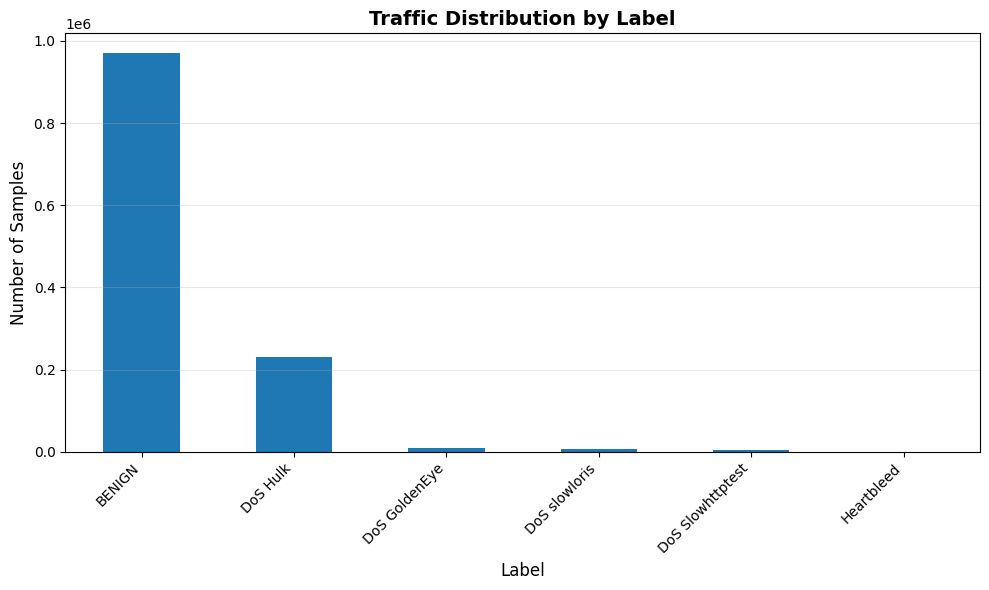

In [7]:
# Bar chart
plt.figure(figsize=(10, 6))
label_counts = dataset[' Label'].value_counts()
label_counts.plot(kind='bar')
plt.title('Traffic Distribution by Label', fontsize=14, fontweight='bold')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 1.2 Dataset Preprocessing

In [29]:
# Data cleaning
# Create a copy to avoid modifying the original dataset
df_processed = dataset.copy()

print(f"Initial shape: {df_processed.shape}")

# Handle missing values
missing_before = df_processed.isnull().sum().sum()
print(f"\nMissing values before cleaning: {missing_before}")

# Fill or drop missing values (strategy: drop rows with missing values)
df_processed = df_processed.dropna()
print(f"Missing values after cleaning: {df_processed.isnull().sum().sum()}")

# Handle infinite values
print(f"\nHandling infinite values...")
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop(' Label', errors='ignore')

# Replace infinite values with NaN, then replace with column median
for col in numerical_cols:
    inf_mask = df_processed[col].isin([float('inf'), float('-inf')])
    if inf_mask.any():
        print(f"  - Found {inf_mask.sum()} infinite values in '{col}'")
        df_processed.loc[inf_mask, col] = df_processed[col].replace([float('inf'), float('-inf')], float('nan'))
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

print(f"\nFinal shape after cleaning: {df_processed.shape}")
print(f"Rows removed: {len(dataset) - len(df_processed)}")

Initial shape: (1222621, 79)

Missing values before cleaning: 1072
Missing values after cleaning: 0

Handling infinite values...
  - Found 662 infinite values in 'Flow Bytes/s'
  - Found 662 infinite values in ' Flow Packets/s'


C:\Users\trist\AppData\Local\Temp\ipykernel_22920\161017512.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(df_processed[col].median(), inplace=True)
C:\Users\trist\AppData\Local\Temp\ipykernel_22920\161017512.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a


Final shape after cleaning: (1221549, 79)
Rows removed: 1072


In [30]:
# Separate features (X) and labels (y)
X = df_processed.drop(' Label', axis=1)
y = df_processed[' Label']

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nLabel distribution:")
print(y.value_counts())

Features shape: (1221549, 78)
Labels shape: (1221549,)

Label distribution:
 Label
BENIGN              969826
DoS Hulk            230124
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64


In [31]:
# Encoding categorical features

# Check for categorical features in X
categorical_features = X.select_dtypes(include=['object']).columns
print(f"\nCategorical features in X: {list(categorical_features)}")

if len(categorical_features) > 0:
    print(f"Found {len(categorical_features)} categorical feature(s) to encode")
    # Apply One-Hot Encoding for categorical features if any exist
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        print(f"  - Encoded '{col}'")
else:
    print("No categorical features found in features (X) - all features are numerical")

# Encode target labels (y) - convert attack names to numerical labels
print(f"\nEncoding target labels (y)...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Label mapping:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"  {label:20s} → {idx}")

print(f"\nEncoded labels shape: {y_encoded.shape}")


Categorical features in X: []
No categorical features found in features (X) - all features are numerical

Encoding target labels (y)...
Label mapping:
  BENIGN               → 0
  DoS GoldenEye        → 1
  DoS Hulk             → 2
  DoS Slowhttptest     → 3
  DoS slowloris        → 4
  Heartbleed           → 5

Encoded labels shape: (1221549,)


In [32]:
# Feature Standardization (Z-Score Normalization)
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

print(f"Original features shape: {X.shape}")
print(f"Scaled features shape: {X_scaled.shape}")

# Show statistics before and after scaling
print(f"\nBefore scaling (first feature):")
print(f"\tMean: {X.iloc[:, 0].mean():.4f}")
print(f"\tStd:  {X.iloc[:, 0].std():.4f}")
print(f"\tMin:  {X.iloc[:, 0].min():.4f}")
print(f"\tMax:  {X.iloc[:, 0].max():.4f}")

print(f"\nAfter scaling (first feature):")
print(f"\tMean: {X_scaled[:, 0].mean():.4f}")
print(f"\tStd:  {X_scaled[:, 0].std():.4f}")
print(f"\tMin:  {X_scaled[:, 0].min():.4f}")
print(f"\tMax:  {X_scaled[:, 0].max():.4f}")

Original features shape: (1221549, 78)
Scaled features shape: (1221549, 78)

Before scaling (first feature):
	Mean: 7839.1923
	Std:  18564.1924
	Min:  0.0000
	Max:  65535.0000

After scaling (first feature):
	Mean: -0.0000
	Std:  1.0000
	Min:  -0.4223
	Max:  3.1079


In [33]:
# Dataset Splitting (70% Train, 15% Validation, 15% Test)

# First split: separate test set (15% of total data)
# stratify ensures attack distribution is maintained in all sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_encoded
)

# Second split: separate training and validation from remaining 85%
# 70% train + 15% validation = 85% total
# To get 15% validation from 85%: 15/85 = 0.176
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.176, 
    random_state=42, 
    stratify=y_temp
)

print(f"\nDataset split completed:")
print(f"\tTraining set:   {X_train.shape[0]:6,} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"\tValidation set: {X_val.shape[0]:6,} samples ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"\tTest set:       {X_test.shape[0]:6,} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"\tTotal:          {len(X_scaled):6,} samples (100.0%)")

# Verify stratification - check label distribution in each set
print(f"\nLabel distribution verification:")

for set_name, y_set in [("Training", y_train), ("Validation", y_val), ("Test", y_test)]:
    unique, counts = np.unique(y_set, return_counts=True)
    print(f"\n\t{set_name} set:")
    for label_idx, count in zip(unique, counts):
        label_name = label_encoder.classes_[label_idx]
        percentage = (count / len(y_set)) * 100
        print(f"\t\t{label_name:20s}: {count:6,} ({percentage:5.2f}%)")


Dataset split completed:
	Training set:   855,572 samples (70.0%)
	Validation set: 182,744 samples (15.0%)
	Test set:       183,233 samples (15.0%)
	Total:          1,221,549 samples (100.0%)

Label distribution verification:

	Training set:
		BENIGN              : 679,266 (79.39%)
		DoS GoldenEye       :  7,209 ( 0.84%)
		DoS Hulk            : 161,179 (18.84%)
		DoS Slowhttptest    :  3,851 ( 0.45%)
		DoS slowloris       :  4,060 ( 0.47%)
		Heartbleed          :      7 ( 0.00%)

	Validation set:
		BENIGN              : 145,086 (79.39%)
		DoS GoldenEye       :  1,540 ( 0.84%)
		DoS Hulk            : 34,426 (18.84%)
		DoS Slowhttptest    :    823 ( 0.45%)
		DoS slowloris       :    867 ( 0.47%)
		Heartbleed          :      2 ( 0.00%)

	Test set:
		BENIGN              : 145,474 (79.39%)
		DoS GoldenEye       :  1,544 ( 0.84%)
		DoS Hulk            : 34,519 (18.84%)
		DoS Slowhttptest    :    825 ( 0.45%)
		DoS slowloris       :    869 ( 0.47%)
		Heartbleed          :      2 ( 0.00%)


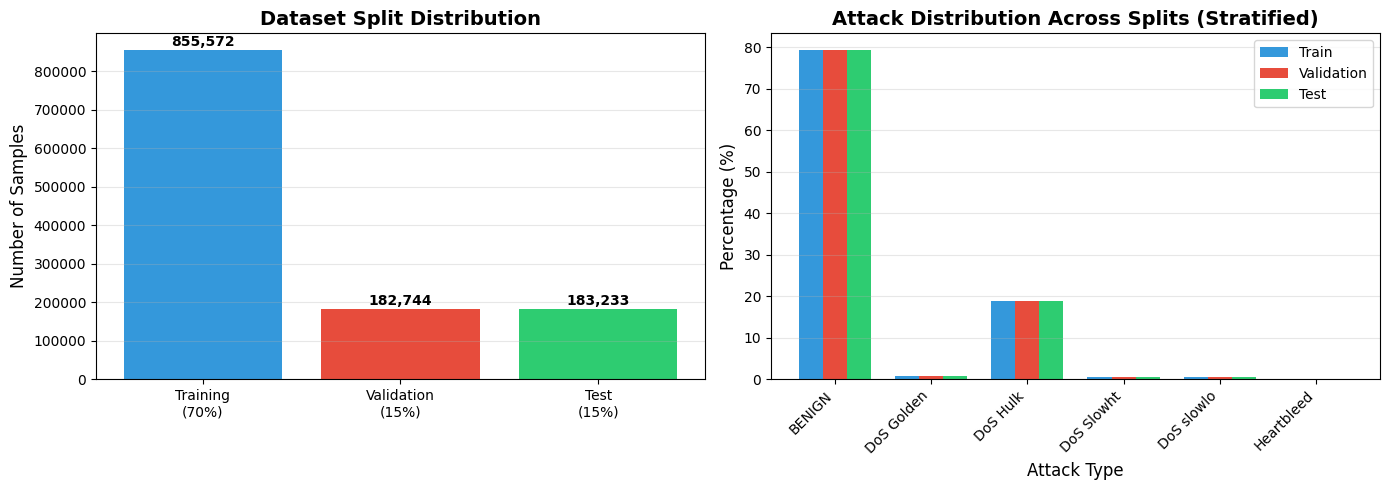

In [19]:
# Visualize the data split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Split sizes
split_sizes = [len(X_train), len(X_val), len(X_test)]
split_labels = ['Training\n(70%)', 'Validation\n(15%)', 'Test\n(15%)']
colors = ['#3498db', '#e74c3c', '#2ecc71']

axes[0].bar(split_labels, split_sizes, color=colors)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (label, size) in enumerate(zip(split_labels, split_sizes)):
    axes[0].text(i, size + 1000, f'{size:,}', ha='center', va='bottom', fontweight='bold')

# Attack distribution across splits
train_dist = np.bincount(y_train) / len(y_train) * 100
val_dist = np.bincount(y_val) / len(y_val) * 100
test_dist = np.bincount(y_test) / len(y_test) * 100

x = np.arange(len(label_encoder.classes_))
width = 0.25

axes[1].bar(x - width, train_dist, width, label='Train', color=colors[0])
axes[1].bar(x, val_dist, width, label='Validation', color=colors[1])
axes[1].bar(x + width, test_dist, width, label='Test', color=colors[2])

axes[1].set_xlabel('Attack Type', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].set_title('Attack Distribution Across Splits (Stratified)', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([label[:10] for label in label_encoder.classes_], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Classical Machine Learning Models for IDS
## 2.1. Logistic Regression for Intrusion Detection

In [34]:
# Train Logistic Regression model

# Initialize model with parameters suitable for multi-class classification
lr_model = LogisticRegression(
    max_iter=1000,
    multi_class='ovr',  # One-vs-Rest for multi-class
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Train the model
print("\nTraining model on training set...")
lr_model.fit(X_train, y_train)
print("Model training completed")

# Make predictions
print("\nMaking predictions...")
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)
y_test_pred = lr_model.predict(X_test)

# Get prediction probabilities for ROC-AUC
y_train_proba = lr_model.predict_proba(X_train)
y_val_proba = lr_model.predict_proba(X_val)
y_test_proba = lr_model.predict_proba(X_test)

print("Predictions completed")


Training model on training set...


C:\Users\trist\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   18.5s remaining:   18.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   55.0s finished


Model training completed

Making predictions...
Predictions completed


In [35]:
# Evaluation Metrics

# Calculate metrics for each dataset
for set_name, y_true, y_pred, y_proba in [
    ("Training", y_train, y_train_pred, y_train_proba),
    ("Validation", y_val, y_val_pred, y_val_proba),
    ("Test", y_test, y_test_pred, y_test_proba)
]:
    print(f"\n{set_name} Set Performance:")
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Precision, Recall, F1-Score (weighted average for multi-class)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"Precision: {precision:.4f} (weighted avg)")
    print(f"Recall:    {recall:.4f} (weighted avg)")
    print(f"F1-Score:  {f1:.4f} (weighted avg)")
    
    # ROC-AUC (One-vs-Rest for multi-class)
    try:
        roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
        print(f"ROC-AUC:   {roc_auc:.4f} (weighted avg)")
    except Exception as e:
        print(f"ROC-AUC:   Could not compute ({str(e)})")


Training Set Performance:
Accuracy:  0.9921 (99.21%)
Precision: 0.9920 (weighted avg)
Recall:    0.9921 (weighted avg)
F1-Score:  0.9917 (weighted avg)
ROC-AUC:   0.9992 (weighted avg)

Validation Set Performance:
Accuracy:  0.9917 (99.17%)
Precision: 0.9916 (weighted avg)
Recall:    0.9917 (weighted avg)
F1-Score:  0.9913 (weighted avg)
ROC-AUC:   0.9992 (weighted avg)

Test Set Performance:
Accuracy:  0.9919 (99.19%)
Precision: 0.9918 (weighted avg)
Recall:    0.9919 (weighted avg)
F1-Score:  0.9915 (weighted avg)
ROC-AUC:   0.9992 (weighted avg)


In [36]:
# Detailed classification report for the test set

# Generate classification report
target_names = label_encoder.classes_
report = classification_report(y_test, y_test_pred, target_names=target_names, zero_division=0)
print(report)

precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_test_pred, labels=range(len(target_names)), zero_division=0
)

metrics_df = pd.DataFrame({
    'Attack Type': target_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support_per_class
})

print("\nPer-Class Metrics Summary:")
display(metrics_df)

                  precision    recall  f1-score   support

          BENIGN       0.99      1.00      1.00    145474
   DoS GoldenEye       0.96      0.90      0.92      1544
        DoS Hulk       0.98      1.00      0.99     34519
DoS Slowhttptest       0.89      0.80      0.85       825
   DoS slowloris       0.95      0.51      0.66       869
      Heartbleed       0.50      0.50      0.50         2

        accuracy                           0.99    183233
       macro avg       0.88      0.78      0.82    183233
    weighted avg       0.99      0.99      0.99    183233


Per-Class Metrics Summary:


,Attack Type,Precision,Recall,F1-Score,Support
0,BENIGN,0.9947,0.9955,0.9951,145474
1,DoS GoldenEye,0.9564,0.8951,0.9247,1544
2,DoS Hulk,0.9846,0.9979,0.9912,34519
3,DoS Slowhttptest,0.8923,0.8036,0.8457,825
4,DoS slowloris,0.9467,0.5109,0.6637,869
5,Heartbleed,0.5000,0.5000,0.5000,2


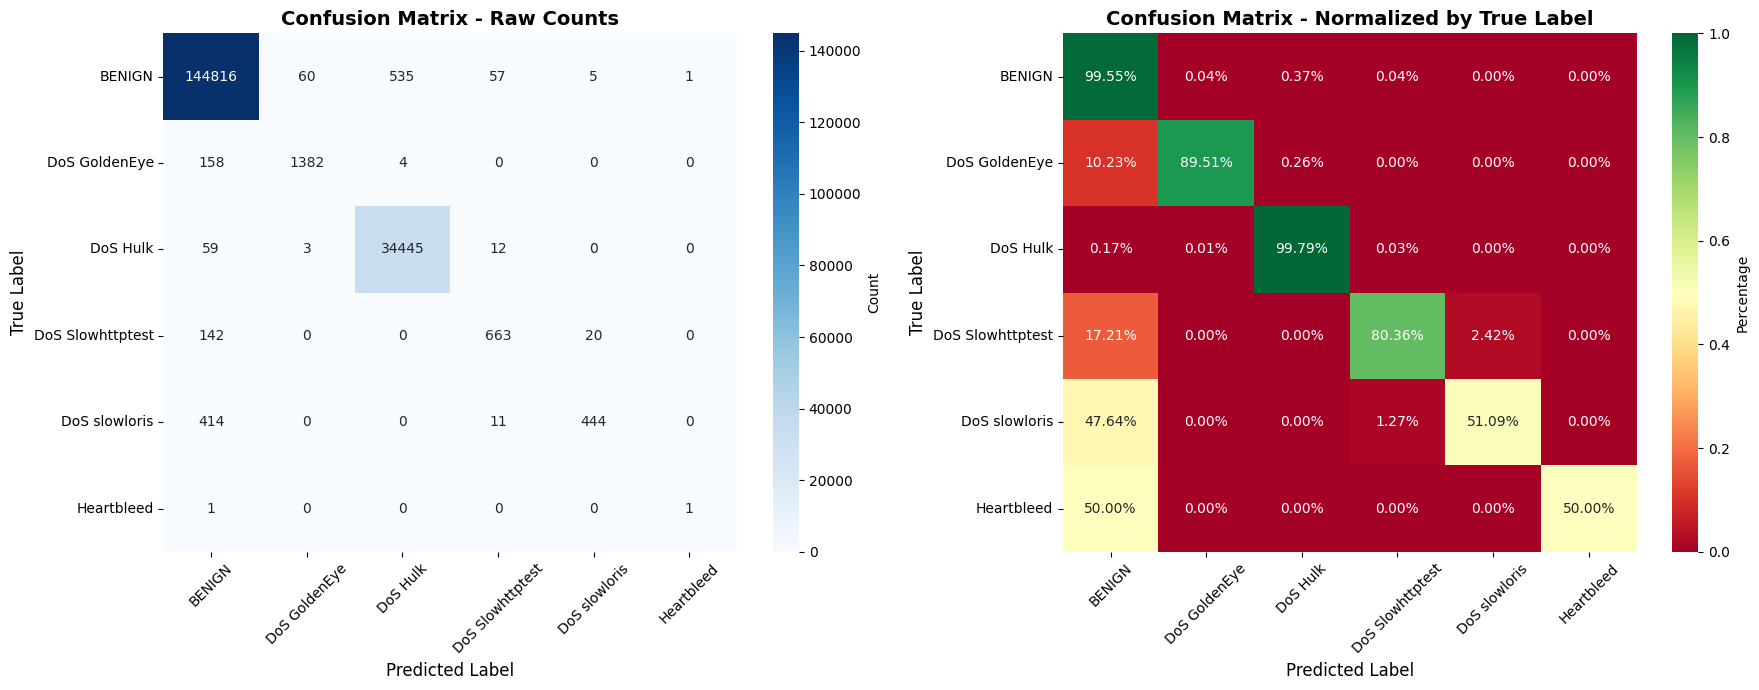


Key Observations from Confusion Matrix:
BENIGN              : 144,816/145,474 correct (99.55%)
DoS GoldenEye       :  1,382/ 1,544 correct (89.51%)
DoS Hulk            : 34,445/34,519 correct (99.79%)
DoS Slowhttptest    :    663/   825 correct (80.36%)
DoS slowloris       :    444/   869 correct (51.09%)
Heartbleed          :      1/     2 correct (50.00%)


In [37]:
# Confusion Matrix Visualization

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Raw Counts', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Plot 2: Normalized (percentage per true class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=axes[1],
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Percentage'}, vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix - Normalized by True Label', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Print key observations
print("\nKey Observations from Confusion Matrix:")

# Diagonal elements (correct predictions)
correct_predictions = np.diag(cm)
total_per_class = cm.sum(axis=1)

for i, class_name in enumerate(target_names):
    accuracy_per_class = correct_predictions[i] / total_per_class[i] if total_per_class[i] > 0 else 0
    print(f"{class_name:20s}: {correct_predictions[i]:6,}/{total_per_class[i]:6,} correct ({accuracy_per_class*100:5.2f}%)")


False Positives and False Negatives by Class:


,Attack Type,True Positives,False Positives,False Negatives,FP Rate,FN Rate
0,BENIGN,144816,774,658,0.0205,0.0045
1,DoS GoldenEye,1382,63,162,0.0003,0.1049
2,DoS Hulk,34445,539,74,0.0036,0.0021
3,DoS Slowhttptest,663,80,162,0.0004,0.1964
4,DoS slowloris,444,25,425,0.0001,0.4891
5,Heartbleed,1,1,1,0.0000,0.5000



Overall Statistics:
  Total False Positives: 1,482 (0.81%)
  Total False Negatives: 1,482 (0.81%)


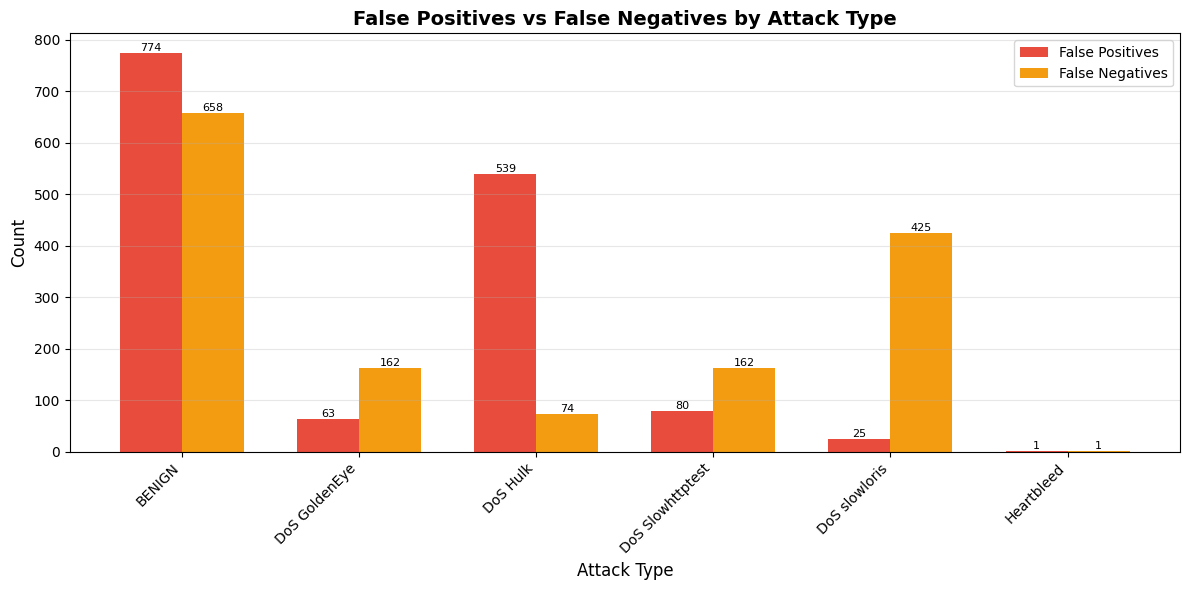

In [38]:
# False Positives vs False Negatives Analysis

# Calculate FP and FN for each class
false_positives = cm.sum(axis=0) - np.diag(cm)  # Sum of column - diagonal
false_negatives = cm.sum(axis=1) - np.diag(cm)  # Sum of row - diagonal
true_positives = np.diag(cm)
true_negatives = cm.sum() - (false_positives + false_negatives + true_positives)

# Create summary table
fp_fn_df = pd.DataFrame({
    'Attack Type': target_names,
    'True Positives': true_positives,
    'False Positives': false_positives,
    'False Negatives': false_negatives,
    'FP Rate': false_positives / (false_positives + true_negatives) if (false_positives + true_negatives).any() else 0,
    'FN Rate': false_negatives / (false_negatives + true_positives)
})

print("\nFalse Positives and False Negatives by Class:")
display(fp_fn_df)

# Overall FP and FN
total_fp = false_positives.sum()
total_fn = false_negatives.sum()
total_predictions = cm.sum()

print(f"\nOverall Statistics:")
print(f"  Total False Positives: {total_fp:,} ({total_fp/total_predictions*100:.2f}%)")
print(f"  Total False Negatives: {total_fn:,} ({total_fn/total_predictions*100:.2f}%)")

# Visualize FP vs FN
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(target_names))
width = 0.35

bars1 = ax.bar(x - width/2, false_positives, width, label='False Positives', color='#e74c3c')
bars2 = ax.bar(x + width/2, false_negatives, width, label='False Negatives', color='#f39c12')

ax.set_xlabel('Attack Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('False Positives vs False Negatives by Attack Type', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height):,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()